In [77]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [78]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AvkRcIYAvUA2WtYkRunR")
project = rf.workspace().project("parcel-damage-classification")
dataset = project.version(2).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Parcel-Damage-Classification-2 in folder:: 100%|██████████| 1011/1011 [00:00<00:00, 3758.54it/s]


In [79]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder(dataset.location + '/train/', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder(dataset.location + '/valid/', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder(dataset.location + '/test/', transform=ToTensor())

## Define the Model

In [80]:
!pip install transformers
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Define the Model Parameters

To train this model, we will train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5:

In [81]:
EPOCHS = 3
BATCH_SIZE = 4
LEARNING_RATE = 2e-5

We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

In [82]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.


## Train the Model

In [83]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

# Train the model
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss = model(b_x, None)
    # Calculate loss
    if loss is None: 
      loss = loss_func(output, b_y)   
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()

    if step % 50 == 0:
      # Get the next batch for testing purposes
      test = next(iter(test_loader))
      test_x = test[0]
      # Reshape and get feature matrices as needed
      test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
      for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
      test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
      test_x = test_x.to(device)
      test_y = test[1].to(device)
      # Get output (+ respective class) and compare to target
      test_output, loss = model(test_x, test_y)
      test_output = test_output.argmax(1)
      # Calculate Accuracy
      accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

Number of train samples:  704
Number of test samples:  99
Detected Classes are:  {'damagedpackages': 0, 'undamagedpackages': 1}


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch:  0 | train loss: 0.6715 | test accuracy: 0.75
Epoch:  0 | train loss: 0.6137 | test accuracy: 0.75
Epoch:  0 | train loss: 0.6946 | test accuracy: 0.50
Epoch:  0 | train loss: 0.7033 | test accuracy: 0.50
Epoch:  1 | train loss: 0.6901 | test accuracy: 0.75
Epoch:  1 | train loss: 0.6910 | test accuracy: 0.50
Epoch:  1 | train loss: 0.5706 | test accuracy: 1.00
Epoch:  1 | train loss: 0.7053 | test accuracy: 0.25
Epoch:  2 | train loss: 0.7310 | test accuracy: 0.25
Epoch:  2 | train loss: 0.7076 | test accuracy: 0.25
Epoch:  2 | train loss: 0.7207 | test accuracy: 0.25
Epoch:  2 | train loss: 0.7149 | test accuracy: 0.00


## Evaluate on a Test Image

Finally, let's evaluate the model on a test image:

In [84]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(test_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
predicted_class = []
actual_class = []

for inputs, target in iter(eval_loader):

  # Disable grad
  with torch.no_grad():
      

    # Reshape and get feature matrices as needed
    print(inputs.shape)
    inputs = inputs[0].permute(1, 2, 0)
    # Save original Input
    originalInput = inputs
    for index, array in enumerate(inputs):
      inputs[index] = np.squeeze(array)
    inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

    # Send to appropriate computing device
    inputs = inputs.to(device)
    target = target.to(device)
  
    # Generate prediction
    prediction, loss = model(inputs, target)
      
    # Predicted class value using argmax
    predicted_classif = np.argmax(prediction.cpu())
    value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_classif)]
    value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
          
    actual_class.append(target.detach().cpu().numpy()[0])
    predicted_class.append(predicted_classif.detach().cpu().numpy())
    #predicted_list.append()
    # Show result
    # plt.imshow(originalInput)
    # plt.xlim(224,0)
    # plt.ylim(224,0)
    # plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
    # plt.show()

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1,

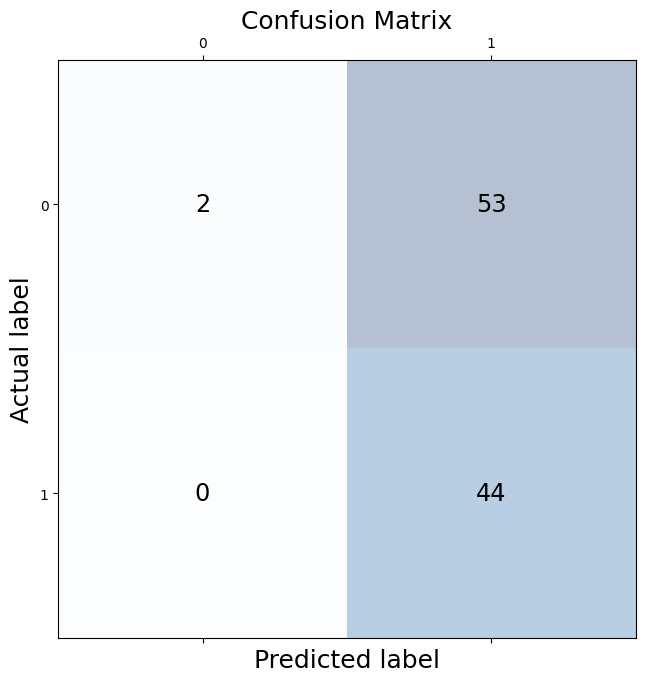

Accuracy: 0.46464646464646464
Precision: 0.03636363636363636
Recall: 1.0
Specificity: 0.4536082474226804
F1-Score: 0.07017543859649122


In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(actual_class, predicted_class) #creates confusion matrix from predictions and actuals
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('Actual label', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
recall = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])

print("Accuracy:",  (conf_matrix[0][0]+conf_matrix[1][1])/((conf_matrix[0][0]+conf_matrix[0][1])+(conf_matrix[1][0]+conf_matrix[1][1])))
print("Precision:",  precision)
print("Recall:",  recall)
print("Specificity:",  (conf_matrix[1][1])/(conf_matrix[1][1]+conf_matrix[0][1]))
print("F1-Score:",  (2*precision * recall)/(precision+recall))


## Save the Entire Model

We can save the entire model as follows:

In [86]:
torch.save(model, '/content/model.pt')

## Export Trained Model

In [87]:
from google.colab import drive
drive.mount('/content/gdrive')

%cp /content/model.pt /content/gdrive/My\ Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Use your Exported Model

In [88]:
MODEL_PATH = '/content/model.pt'
model = torch.load(MODEL_PATH)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7